In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.visualization import quantity_support
from astropy.visualization import simple_norm
from astropy.modeling import models, fitting
from astropy.nddata import NDData
from astropy.wcs import WCS
from spectral_cube import SpectralCube, Projection,  BooleanArrayMask
from pvextractor import Path, extract_pv_slice


matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

### PVextractor GUI to be run from the terminal

```python
from pvextractor.gui import PVSlicer

pv = PVSlicer('/media/sanjana/One Touch/Toolkit/OutflowProject/ALMAData/I14498_spw29_CO_PlusMinus_150.0kmps_1_ChAvg_VelStep_0.847kmps.fits')
pv.show()


# Code

In [2]:
SpeedOfLight = 299792458  # Speed of light in m/s

def gaussian(x, amp, cen, wid):
    """1-d Gaussian: gaussian(x, amp, cen, wid)"""
    return amp * np.exp(-(x - cen)**2 / (2 * wid**2))

def parse_ds9_reg_file(reg_file):
    with open(reg_file, 'r') as f:
        lines = f.readlines()

    shape_params = None
    shape_type = None

    for line in lines:
        line = line.strip()
        if line.startswith('ellipse'):
            shape_type = 'ellipse'
            params_str = line.split('(')[1].split(')')[0]
            shape_params = [float(param) for param in params_str.split(',')]
        elif line.startswith('circle'):
            shape_type = 'circle'
            params_str = line.split('(')[1].split(')')[0]
            shape_params = [float(param) for param in params_str.split(',')]

    if shape_params is None:
        raise ValueError("No recognized shape found in the region file.")

    return shape_type, shape_params

def calculate_bounds(shape_type, shape_params):
    if shape_type == 'ellipse':
        center_x = shape_params[0]
        center_y = shape_params[1]
        semi_major_axis = shape_params[2]
        semi_minor_axis = shape_params[3]

        xmin = center_x - semi_major_axis
        xmax = center_x + semi_major_axis
        ymin = center_y - semi_minor_axis
        ymax = center_y + semi_minor_axis
    elif shape_type == 'circle':
        center_x = shape_params[0]
        center_y = shape_params[1]
        radius = shape_params[2]

        xmin = center_x - radius
        xmax = center_x + radius
        ymin = center_y - radius
        ymax = center_y + radius
    else:
        raise ValueError("Unsupported shape type.")

    return int(xmin), int(xmax), int(ymin), int(ymax)


def pv_input_file(output_path, output_name):
    file_dir = os.path.join(output_path, f'{output_name}')
    for root, dirs, files in os.walk(file_dir):
        for file in files:
            if file.endswith(".fits"):
                return os.path.join(root, file)
    
    raise FileNotFoundError(f"No fits file found in {file_dir}")
'''
def plot_pv_diagram(fits_file, output_name, v_lsr, path_reg_files, distance, savefig):
    output_path = '/media/sanjana/One Touch/Toolkit/OutflowProject/ALMAData/'

    # Process each path region file
    for reg_file in path_reg_files:
        # Parse the region file
        with open(reg_file, 'r') as f:
            lines = f.readlines()

        points = []
        for line in lines:
            line = line.strip()
            if line.startswith('point'):
                params_str = line.split('(')[1].split(')')[0]
                x, y = [float(param) for param in params_str.split(',')]
                points.append((x, y))

        if not points:
            raise ValueError(f"No valid path points found in {reg_file}")

        # Set the path width (adjust as needed)
        path_width = 10.0  # Width of the path in pixels

        # Create a Path object
        path = Path(points, width=path_width)

        pv_fits_file = pv_input_file(output_path, output_name)
        cube = SpectralCube.read(pv_fits_file)

        # Convert v_lsr to velocity index
        velocity_axis = cube.spectral_axis.to('km/s').value
       
        v_lsr_index = np.abs(velocity_axis - v_lsr).argmin()
        print(f"v_lsr index: {v_lsr_index}")

        # Define the range around v_lsr for extraction
        delta_v = 20  # km/s range around v_lsr
        upper_bound = np.abs(velocity_axis - (v_lsr - delta_v)).argmin()
        lower_bound = np.abs(velocity_axis - (v_lsr + delta_v)).argmin()
        print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")

        if lower_bound > upper_bound:
            lower_bound, upper_bound = upper_bound, lower_bound

        # Extract the PV slice
        sub_cube = cube[lower_bound:upper_bound+1, :, :]
        print(f"Sub-cube shape: {sub_cube.shape}")

        pv_slice = extract_pv_slice(sub_cube, path)
        print(f"PV slice shape: {pv_slice.shape}")

        # Plot the PV diagram
        plt.figure(figsize=(5, 3))
        plt.imshow(pv_slice.data, origin='lower', aspect='auto', cmap='inferno')
        plt.xlabel('Offset along path')
        plt.ylabel('Velocity frame')
        plt.colorbar(label='Intensity')
        plt.title(f'PV Diagram: {os.path.splitext(os.path.basename(reg_file))[0]}')  # Use reg file name as title

        if savefig:
            # Create the output directory if it doesn't exist
            save_dir = os.path.join(output_path, f'{output_name}', 'pv_diagrams')
            os.makedirs(save_dir, exist_ok=True)
            # Save the figure with the same name as the reg file but with _pv.pdf extension
            save_path = os.path.join(save_dir, f"{os.path.splitext(os.path.basename(reg_file))[0]}_pv.pdf")
            plt.savefig(save_path)

            # Save the PV slice as a FITS file
            pv_fits_save_path = os.path.join(save_dir, f"{os.path.splitext(os.path.basename(reg_file))[0]}_pv.fits")
            hdu = fits.PrimaryHDU(data=pv_slice.data, header=cube.header)
            hdu.writeto(pv_fits_save_path, overwrite=True)

        plt.show()
'''
def save_moment_maps_from_data(data, header, output_name, output_dir, savefig, v_lsr):
    # Create directories for FITS files and figures under the output name directory
    output_path = os.path.join(output_dir, output_name)
    fits_dir = os.path.join(output_path, 'moments_fits_files')
    figures_dir = os.path.join(output_path, 'figures')
    os.makedirs(fits_dir, exist_ok=True)
    os.makedirs(figures_dir, exist_ok=True)

    '''

    # Calculate the 0th, 1st, and 2nd moment maps
    moment0 = np.nansum(data[:], axis=0)
    moment1 = np.nansum(data[:] * np.arange(data.shape[0])[:, np.newaxis, np.newaxis], axis=0) / moment0

    # Calculate moment2
    velocity_axis = np.arange(data.shape[0])[:, np.newaxis, np.newaxis]
    moment2 = np.sqrt(np.nansum(data[:] * (velocity_axis - moment1)**2, axis=0) / moment0)
    '''
    moment0 = np.nansum(data[:], axis=0)

    # Calculate the velocity axis if not provided
    velocity_axis = np.arange(data.shape[0])
    # Ensure velocity_axis has the correct shape
    velocity_axis = velocity_axis[:, np.newaxis, np.newaxis]

    # Calculate the 1st moment map
    moment1 = np.nansum(data[:] * velocity_axis, axis=0) / moment0

    # Broadcast moment1 to match the shape of data
    moment1_broadcast = moment1[np.newaxis, :, :]

    # Calculate the 2nd moment map
    moment2 = np.sqrt(np.nansum(data[:] * (velocity_axis - moment1_broadcast)**2, axis=0) / moment0)

    # Save the moment maps as FITS files
    moment0_hdu = fits.PrimaryHDU(data=moment0, header=header)
    moment1_hdu = fits.PrimaryHDU(data=moment1, header=header)
    moment2_hdu = fits.PrimaryHDU(data=moment2, header=header)

    moment0_file = os.path.join(fits_dir, f'{output_name}_moment0.fits')
    moment1_file = os.path.join(fits_dir, f'{output_name}_moment1.fits')
    moment2_file = os.path.join(fits_dir, f'{output_name}_moment2.fits')

    moment0_hdu.writeto(moment0_file, overwrite=True)
    moment1_hdu.writeto(moment1_file, overwrite=True)
    moment2_hdu.writeto(moment2_file, overwrite=True)
    '''
     # Create a SpectralCube from the data and header
    cube = SpectralCube(data=data, wcs=WCS(header))

    # Calculate the 0th, 1st, and 2nd moment maps using SpectralCube
    moment0 = cube.moment(order=0)
    moment1 = cube.moment(order=1)
    moment2 = cube.moment(order=2)

    # Save the moment maps as FITS files
    moment0_file = os.path.join(fits_dir, f'{output_name}_moment0.fits')
    moment1_file = os.path.join(fits_dir, f'{output_name}_moment1.fits')
    moment2_file = os.path.join(fits_dir, f'{output_name}_moment2.fits')

    moment0.write(moment0_file, overwrite=True)
    moment1.write(moment1_file, overwrite=True)
    moment2.write(moment2_file, overwrite=True)
    '''
    vmin = v_lsr - 3
    vmax = v_lsr + 3

    # Plot and save figures under the figures directory
    plt.figure()
    norm0 = simple_norm(moment0, 'sqrt', percent=85)
    plt.imshow(moment0, origin='lower', cmap='inferno', norm=norm0)
    plt.colorbar()
    plt.title(f'Moment 0: Integrated Intensity ({output_name})')
    plt.ylabel('Dec frame')
    plt.xlabel('RA frame')
    if savefig:
        plt.savefig(os.path.join(figures_dir, f'{output_name}_moment0.pdf'))
    plt.show()

    plt.figure()
    norm1 = simple_norm(moment1, 'sqrt', percent=85)
    plt.imshow(moment1, origin='lower', cmap='coolwarm', norm=norm1)
    plt.colorbar()
    plt.title(f'Moment 1: Intensity-Weighted Velocity ({output_name})')
    plt.ylabel('Dec frame')
    plt.xlabel('RA frame')
    if savefig:
        plt.savefig(os.path.join(figures_dir, f'{output_name}_moment1.pdf'))
    plt.show()

    plt.figure()
    norm2 = simple_norm(moment2, 'sqrt', percent=85)
    plt.imshow(moment2, origin='lower', cmap='viridis', norm=norm2)
    plt.colorbar()
    plt.title(f'Moment 2: Velocity Dispersion ({output_name})')
    plt.ylabel('Dec frame')
    plt.xlabel('RA frame')
    if savefig:
        plt.savefig(os.path.join(figures_dir, f'{output_name}_moment2.pdf'))
    plt.show()

def process_spectral_cube(fits_file, reg_file, v_lsr, output_name, savefig=True):
    output_path = os.path.join(os.path.dirname(fits_file), output_name)
    os.makedirs(output_path, exist_ok=True)

    if output_name[-4:] == 'HCO+':
        with fits.open(fits_file) as hdul:
            data = hdul[0].data
            header = hdul[0].header
        
        crval3 = header['CRVAL3']
        cdelt3 = header['CDELT3']
        crpix3 = header['CRPIX3']
        spectral_axis = (np.arange(data.shape[0]) - (crpix3 - 1)) * cdelt3 + crval3

        header['CTYPE3'] = 'VRAD'
        header['CUNIT3'] = 'km/s'

        new_hdu = fits.PrimaryHDU(data=data, header=header)

        output_fits = os.path.join(output_path, f"{output_name}.fits")
        new_hdu.writeto(output_fits, overwrite=True)

        with fits.open(output_fits) as hdul:
            cube_data = hdul[0].data

    elif output_name[-4:] == '_CO_':
        with fits.open(fits_file) as hdul:
            data = hdul[0].data
            header = hdul[0].header
        
        crval3 = header['CRVAL3']
        cdelt3 = header['CDELT3']
        crpix3 = header['CRPIX3']
        RestFreq = header['RESTFRQ']
        V0 = -(SpeedOfLight * (RestFreq - crval3) / RestFreq) / 1000  # Velocity in km/s
        #print('V0=', V0, 'RestFreq=', RestFreq, 'crval3=', crval3)

        FreqRes = float(header['CDELT3'])
        VelRes = -(SpeedOfLight * FreqRes / RestFreq) / 1000  # Velocity resolution in km/s
        #print('VelRes=', VelRes)

        header['CTYPE3'] = 'VRAD'
        header['CDELT3'] = VelRes
        header['CRVAL3'] = V0
        header['CUNIT3'] = 'km/s'

        updated_file = os.path.join(output_path, f'{output_name}_spectral_axis_vel.fits')
        updated_hdu = fits.PrimaryHDU(data=data, header=header)
        updated_hdu.writeto(updated_file, overwrite=True)

        with fits.open(updated_file) as hdul:
            cube_data = hdul[0].data

        spectral_axis = (np.arange(cube_data.shape[0]) - crpix3 + 1) * VelRes + V0  # in km/s

    save_moment_maps_from_data(cube_data, header, output_name, output_path, savefig, v_lsr)

    # Sum over the spatial axes to get intensity vs velocity
    intensity_vs_velocity = np.nansum(cube_data, axis=(1, 2))

    plt.figure(figsize=(5, 3))
    plt.grid(alpha= 0.7, linestyle ='--')
    plt.plot(spectral_axis, intensity_vs_velocity, drawstyle='steps-mid', linewidth=0.5, color='navy')
    plt.xlabel('Velocity (km/s)', fontsize=12)
    plt.ylabel('Integrated Intensity (Jy/beam)', fontsize=12)
    plt.title(f'Intensity vs Velocity ', fontsize=14)
    plt.grid(True)
    figures_dir = os.path.join(output_path, 'figures')
    if savefig:
        os.makedirs(figures_dir, exist_ok=True)
        plt.savefig(os.path.join(figures_dir, f'{output_name}_intensity_vs_velocity.pdf'))
    plt.show()

    # Extract the region of interest from the data cube
    shape_type, shape_params = parse_ds9_reg_file(reg_file)
    xmin, xmax, ymin, ymax = calculate_bounds(shape_type, shape_params)
    region = cube_data[:, ymin:ymax, xmin:xmax]

    # Mean intensity over the region
    intensity = region.mean(axis=(1, 2))

    if output_name[-4:] == 'HCO+':
        popt, _ = curve_fit(gaussian, spectral_axis, intensity, p0=[np.max(intensity), v_lsr, 2.5])
        amp, cen, wid = popt
        fwhm = 2 * np.sqrt(2 * np.log(2)) * abs(wid)
        lower_bound = cen - fwhm / 2
        upper_bound = cen + fwhm / 2
    elif output_name[-4:] == '_CO_':
        lower_bound = v_lsr - 3
        upper_bound = v_lsr + 3

    plt.figure(figsize=(5, 3))
    plt.grid(alpha= 0.7, linestyle ='--')
    plt.plot(spectral_axis, intensity, linewidth=0.5, color='navy', label='Data')
    if output_name[-4:] == 'HCO+':
        plt.plot(spectral_axis, gaussian(spectral_axis, *popt), color='green', linestyle='--', label='Gaussian fit')
    plt.xlabel('Velocity (km/s)', fontsize=12)
    plt.ylabel('Intensity (Jy/beam)', fontsize=12)
    plt.axvline(v_lsr, color='red', linestyle='--', label='$V_{LSR}$')
    plt.title(f'Intensity vs. Velocity of Core', fontsize=14)
    plt.legend()
    if savefig:
        plt.savefig(os.path.join(figures_dir, f'{output_name}_core_intensity_vs_velocity.pdf'))
    plt.show()

    print('lower_bound =', lower_bound, 'upper_bound =', upper_bound)

    # Create masks for low and high velocity regions
    low_mask = spectral_axis < lower_bound
    high_mask = spectral_axis > upper_bound

    # Apply masks to the data cube
    low_mask_3d = low_mask[:, np.newaxis, np.newaxis]
    high_mask_3d = high_mask[:, np.newaxis, np.newaxis]
    cube_low = np.where(low_mask_3d, cube_data, np.nan)
    cube_high = np.where(high_mask_3d, cube_data, np.nan)

    low_output_name = f'{output_name}_blue'
    high_output_name = f'{output_name}_red'

    # Save the red and blue cubes as FITS files
    low_cube_file = os.path.join(output_path, f'{low_output_name}.fits')
    high_cube_file = os.path.join(output_path, f'{high_output_name}.fits')

    low_hdu = fits.PrimaryHDU(data=cube_low, header=header)
    high_hdu = fits.PrimaryHDU(data=cube_high, header=header)

    low_hdu.writeto(low_cube_file, overwrite=True)
    high_hdu.writeto(high_cube_file, overwrite=True)

    # Save the moment maps for low and high velocity regions
    save_moment_maps_from_data(cube_low, header, low_output_name, output_path, savefig, v_lsr)
    save_moment_maps_from_data(cube_high, header, high_output_name, output_path, savefig, v_lsr)

In [3]:
def plot_pv_diagram(fits_file, output_name, v_lsr, path_reg_files, distance_to_object_pc, savefig=True):
    output_path = '/media/sanjana/One Touch/Toolkit/OutflowProject/ALMAData/'

    # Process each path region file
    for reg_file in path_reg_files:
        # Parse the region file
        with open(reg_file, 'r') as f:
            lines = f.readlines()

        points = []
        for line in lines:
            line = line.strip()
            if line.startswith('point'):
                params_str = line.split('(')[1].split(')')[0]
                x, y = [float(param) for param in params_str.split(',')]
                points.append((x, y))

        if not points:
            raise ValueError(f"No valid path points found in {reg_file}")

        # Set the path width (adjust as needed)
        path_width = 10.0  # Width of the path in pixels

        # Create a Path object
        path = Path(points, width=path_width)

        pv_fits_file = pv_input_file(output_path, output_name)
        cube = SpectralCube.read(pv_fits_file)

        # Convert v_lsr to velocity index
        velocity_axis = cube.spectral_axis.to('km/s').value
        v_lsr_index = np.abs(velocity_axis - v_lsr).argmin()
        print(f"v_lsr index: {v_lsr_index}")

        # Define the range around v_lsr for extraction
        delta_v = 30  # km/s range around v_lsr
        upper_bound = np.abs(velocity_axis - (v_lsr - delta_v)).argmin()
        lower_bound = np.abs(velocity_axis - (v_lsr + delta_v)).argmin()
        print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")

        if lower_bound > upper_bound:
            lower_bound, upper_bound = upper_bound, lower_bound

        # Extract the PV slice
        sub_cube = cube[lower_bound:upper_bound+1, :, :]
        print(f"Sub-cube shape: {sub_cube.shape}")

        pv_slice = extract_pv_slice(sub_cube, path)
        print(f"PV slice shape: {pv_slice.shape}")

        # Calculate pixel scale
        pixel_scale_arcsec = np.abs(cube.header['CDELT1']) * 3600  # Convert degrees to arcseconds
        pixel_scale_pc = (pixel_scale_arcsec / 206265) * distance_to_object_pc  # Convert arcseconds to parsecs

        # Convert the offset axis (in pixels) to parsecs
        offset_values_pc = np.arange(pv_slice.shape[1]) * pixel_scale_pc

        # Extract actual velocity values corresponding to the frames
        velocity_values = velocity_axis[lower_bound:upper_bound+1]
        
        # Remove underscores from the region file name for the title
        reg_file_name = os.path.splitext(os.path.basename(reg_file))[0].replace('_', ' ')

        # Plot the PV diagram with actual velocity values and offsets in parsecs
        plt.figure(figsize=(5, 3))
        extent = [offset_values_pc.min(), offset_values_pc.max(), velocity_values.min(), velocity_values.max()]
        plt.imshow(pv_slice.data, origin='lower', aspect='auto', cmap='coolwarm', extent=extent)
        plt.xlabel('Offset along path (pc)')
        plt.ylabel('Velocity (km/s)')
        plt.colorbar(label='Intensity')
        plt.title(f'PV Diagram: {reg_file_name}')

        if savefig:
            # Create the output directory if it doesn't exist
            save_dir = os.path.join(output_path, f'{output_name}', 'pv_diagrams')
            os.makedirs(save_dir, exist_ok=True)
            # Save the figure with the same name as the reg file but with _pv.pdf extension
            save_path = os.path.join(save_dir, f"{os.path.splitext(os.path.basename(reg_file))[0]}_pv.pdf")
            plt.savefig(save_path)

            # Save the PV slice as a FITS file
            pv_fits_save_path = os.path.join(save_dir, f"{os.path.splitext(os.path.basename(reg_file))[0]}_pv.fits")
            hdu = fits.PrimaryHDU(data=pv_slice.data, header=cube.header)
            hdu.writeto(pv_fits_save_path, overwrite=True)

        plt.show()

        # Optionally, save the velocity values and corresponding intensities to a file
        if savefig:
            data_save_path = os.path.join(save_dir, f"{os.path.splitext(os.path.basename(reg_file))[0]}_pv_data.txt")
            with open(data_save_path, 'w') as f:
                f.write("Offset (pc), Velocity (km/s), Intensity\n")
                for i in range(pv_slice.shape[1]):
                    for j in range(pv_slice.shape[0]):
                        f.write(f"{offset_values_pc[i]}, {velocity_values[j]}, {pv_slice.data[j, i]}\n")
            print(f"Velocity, offset, and intensity data saved to {data_save_path}")

## only for easy saving for report

In [4]:
def plot_pv_diagram(fits_file, output_name, v_lsr, path_reg_files, distance_to_object_pc, savefig=True):
    output_path = '/media/sanjana/One Touch/Toolkit/OutflowProject/ALMAData/'
    
    # Process each path region file
    for reg_file in path_reg_files:
        # Parse the region file
        with open(reg_file, 'r') as f:
            lines = f.readlines()

        points = []
        for line in lines:
            line = line.strip()
            if line.startswith('point'):
                params_str = line.split('(')[1].split(')')[0]
                x, y = [float(param) for param in params_str.split(',')]
                points.append((x, y))

        if not points:
            raise ValueError(f"No valid path points found in {reg_file}")

        # Set the path width (adjust as needed)
        path_width = 10.0  # Width of the path in pixels

        # Create a Path object
        path = Path(points, width=path_width)

        pv_fits_file = pv_input_file(output_path, output_name)
        cube = SpectralCube.read(pv_fits_file)

        # Convert v_lsr to velocity index
        velocity_axis = cube.spectral_axis.to('km/s').value
        v_lsr_index = np.abs(velocity_axis - v_lsr).argmin()
        print(f"v_lsr index: {v_lsr_index}")

        # Define the range around v_lsr for extraction
        delta_v = 30  # km/s range around v_lsr
        upper_bound = np.abs(velocity_axis - (v_lsr - delta_v)).argmin()
        lower_bound = np.abs(velocity_axis - (v_lsr + delta_v)).argmin()
        print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")

        if lower_bound > upper_bound:
            lower_bound, upper_bound = upper_bound, lower_bound

        # Extract the PV slice
        sub_cube = cube[lower_bound:upper_bound+1, :, :]
        print(f"Sub-cube shape: {sub_cube.shape}")

        pv_slice = extract_pv_slice(sub_cube, path)
        print(f"PV slice shape: {pv_slice.shape}")

        # Calculate pixel scale
        pixel_scale_arcsec = np.abs(cube.header['CDELT1']) * 3600  # Convert degrees to arcseconds
        pixel_scale_pc = (pixel_scale_arcsec / 206265) * distance_to_object_pc  # Convert arcseconds to parsecs

        # Convert the offset axis (in pixels) to parsecs
        offset_values_pc = np.arange(pv_slice.shape[1]) * pixel_scale_pc

        # Extract actual velocity values corresponding to the frames
        velocity_values = velocity_axis[lower_bound:upper_bound+1]
        
        # Remove underscores from the region file name for the title
        reg_file_name = os.path.splitext(os.path.basename(reg_file))[0].replace('_', ' ')

        # Plot the PV diagram with actual velocity values and offsets in parsecs
        plt.figure(figsize=(5, 3))
        extent = [offset_values_pc.min(), offset_values_pc.max(), velocity_values.min(), velocity_values.max()]
        plt.imshow(pv_slice.data, origin='lower', aspect='auto', cmap='seismic', extent=extent)
        plt.xlabel('Offset along path (pc)')
        plt.ylabel('Velocity (km/s)')
        plt.colorbar(label='Intensity')
        plt.title(f'PV Diagram: {reg_file_name}')

        if savefig:
            # Create the output directory if it doesn't exist
            output_path_2 = '/media/sanjana/One Touch/Toolkit/OutflowProject/ALMAData/pv'
            os.makedirs(output_path_2, exist_ok=True)
            # Save the figure with the same name as the reg file but with _pv.pdf extension
            save_path = os.path.join(output_path_2, f"{os.path.splitext(os.path.basename(reg_file))[0]}_pv.pdf")
            plt.savefig(save_path)
        plt.show()


# IRAS 16272-4837

## CO

In [ ]:
if __name__ == "__main__":
    fits_file = '/media/sanjana/One Touch/Toolkit/OutflowProject/ALMAData/I16272_spw29_CO_PlusMinus_150.0kmps_1_ChAvg_VelStep_0.847kmps.fits'
    reg_file = '/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/ds9_16272_CO.reg'
    v_lsr = -46.42
    output_name = 'IRAS 16272-4837 _CO_'
    path_reg_files = ['/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/I6272_CO_blue_down.reg','/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/I6272_CO_blue_left.reg','/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/I6272_CO_blue_right.reg','/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/I6272_CO_red_down.reg','/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/I6272_CO_red_left.reg','/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/I6272_CO_red_right.reg','/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/I6272_CO_red_up.reg','/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/I6272_CO_red_small.reg']
    savefig = True  
    distance = 3.2*1000

    process_spectral_cube(fits_file, reg_file, v_lsr, output_name, savefig)
    plot_pv_diagram(fits_file, output_name, v_lsr, path_reg_files, distance, savefig)

# IRAS 14498-5856

## CO

In [ ]:
if __name__ == "__main__":
    fits_file = '/media/sanjana/One Touch/Toolkit/OutflowProject/ALMAData/I14498_spw29_CO_PlusMinus_150.0kmps_1_ChAvg_VelStep_0.847kmps.fits'
    reg_file = '/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/ds9_14498_CO.reg'
    v_lsr = -50.03
    output_name = 'IRAS 14498-5856 _CO_'
    path_reg_files = ['/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/I4498_CO_bipolar_h.reg','/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/I4498_CO_bipolar_v.reg', '/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/I4498_CO_red_upperright.reg', '/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/I4498_CO_red_left.reg', '/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/I4498_CO_red_down.reg']
    savefig = True
    distance = 3.2*1000

    process_spectral_cube(fits_file, reg_file, v_lsr, output_name, savefig)
    plot_pv_diagram(fits_file, output_name, v_lsr, path_reg_files, distance, savefig)

## HCO

v_lsr index: 1046
Lower bound: 1339, Upper bound: 754
Sub-cube shape: (586, 200, 200)

PV slice shape: (586, 153)


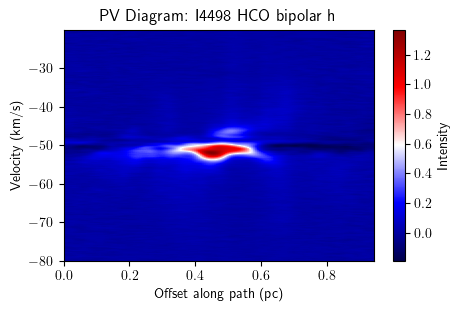

v_lsr index: 1046
Lower bound: 1339, Upper bound: 754
Sub-cube shape: (586, 200, 200)

PV slice shape: (586, 140)


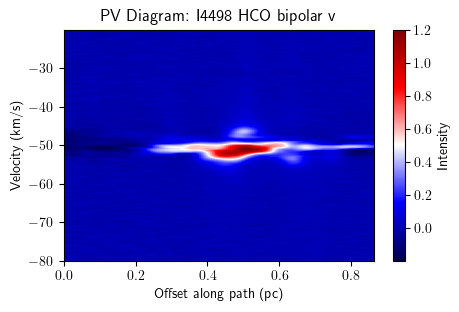

v_lsr index: 1046
Lower bound: 1339, Upper bound: 754
Sub-cube shape: (586, 200, 200)

PV slice shape: (586, 55)


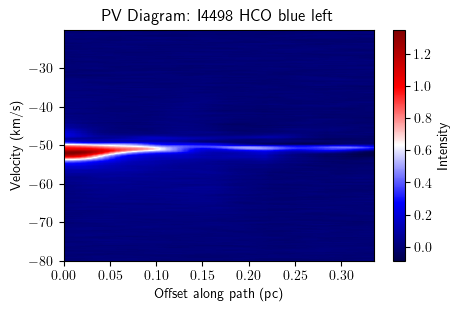

In [5]:
if __name__ == "__main__":
    fits_file = '/media/sanjana/One Touch/Toolkit/OutflowProject/ALMAData/I14498-5856.spw6_HCOp.image.pbcor_InVel.fits'
    reg_file = '/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/ds9_14498_HCO.reg'
    v_lsr = -50.03
    output_name = 'IRAS 14498-5856 HCO+'
    path_reg_files = ['/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/I4498_HCO_bipolar_h.reg','/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/I4498_HCO_bipolar_v.reg','/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/I4498_HCO_blue_left.reg']
    savefig = True  
    distance = 3.2*1000

    #process_spectral_cube(fits_file, reg_file, v_lsr, output_name, savefig)
    plot_pv_diagram(fits_file, output_name, v_lsr, path_reg_files, distance, savefig)

## HCO(4-3)

In [ ]:
'''
if __name__ == "__main__":
    fits_file = '/media/sanjana/One Touch/Toolkit/OutflowProject/ALMAData/IRAS 14498 HCO+(4-3)/IRAS 14498 HCO+(4-3)_spectral_axis_vel.fits'
    reg_file = '/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/ds9_14498_HCO(4-3).reg'
    v_lsr = -50.03
    output_name = 'IRAS 14498-5146 (4-3) HCO+'
    path_reg_files = ['/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/I4498_HCO(4-3)_bipolar.reg']
    savefig = True 
    distance = 3.2*1000

    process_spectral_cube(fits_file, reg_file, v_lsr, output_name, savefig)
    plot_pv_diagram(fits_file, output_name, v_lsr, path_reg_files, distance, savefig)
'''

# IRAS 16060-5146

## CO

In [ ]:
if __name__ == "__main__":
    fits_file = '/media/sanjana/One Touch/Toolkit/OutflowProject/ALMAData/I16060_spw29_CO_PlusMinus_150.0kmps_1_ChAvg_VelStep_0.847kmps.fits'
    reg_file = '/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/ds9_16060_CO.reg'
    v_lsr = -89.95
    output_name = 'IRAS 16060-5146 _CO_'
    path_reg_files = ['/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/I6060_CO_bipolar.reg']
    savefig = True  
    distance = 5.2*1000

    #process_spectral_cube(fits_file, reg_file, v_lsr, output_name, savefig)
    plot_pv_diagram(fits_file, output_name, v_lsr, path_reg_files, distance, savefig)

## HCO

In [ ]:
if __name__ == "__main__":
    fits_file = '/media/sanjana/One Touch/Toolkit/OutflowProject/ALMAData/I16060-5146.spw6_HCOp.image.pbcor_InVel.fits'
    reg_file = '/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/ds9_16060_HCO.reg'
    v_lsr = -89.95
    output_name = 'IRAS 16060-5146 HCO+'
    path_reg_files = ['/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/I6060_HCO_bipolar.reg']
    savefig = True 
    distance = 5.2*1000

    #process_spectral_cube(fits_file, reg_file, v_lsr, output_name, savefig)
    plot_pv_diagram(fits_file, output_name, v_lsr, path_reg_files, distance, savefig)

# HCO (4-3)

In [ ]:
if __name__ == "__main__":
    fits_file = '/media/sanjana/One Touch/Toolkit/OutflowProject/ALMAData/IRAS 16060 HCO+(4-3)/IRAS 14498 HCO+(4-3)_spectral_axis_vel.fits'
    reg_file = '/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/ds9_16060_HCO(4-3).reg'
    v_lsr = -89.95
    output_name = 'IRAS 16060-5146 (4-3) HCO+'
    path_reg_files = ['/home/sanjana/academic++/schools_workshops_internships/SNBNCBS/I6060_HCO(4-3)_bipolar.reg']
    savefig = True 
    distance = 5.2*1000

    process_spectral_cube(fits_file, reg_file, v_lsr, output_name, savefig)
    plot_pv_diagram(fits_file, output_name, v_lsr, path_reg_files, distance, savefig)